In [1]:
from scratch import ArtDataset
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import math
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from model import create_vocab_csv, text_to_tensor

Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!


## Initialize the Dataset

In [2]:
# initialize the dataset and the dataloader
dataset = ArtDataset()

Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!


# Split dataset into train, validation (dev), and test sets
Train: 95%
Validation: 2.5%
Test: 2.5%

In [3]:
# Define the dataset sizes
total_size = len(dataset)
train_size = int(0.95 * total_size)
val_size = int(0.025 * total_size)
test_size = total_size - train_size - val_size

In [4]:
print(train_size, val_size, test_size)

316406 8326 8327


In [5]:
# Split dataset into train, validation (dev), and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
print(len(train_dataset))

316406


In [7]:
# Create DataLoaders for each split
batch = 64
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=2)

## Define the model
We define the model to consist of an embedding layer (to process the text input), and 2 hidden fully-connected layers. 

In [110]:
class ArtPricePredictor(nn.Module):
    def __init__(self, vocab_size_artist, vocab_size_title, embedding_dim_artist, embedding_dim_title, numerical_features_dim):
        super(ArtPricePredictor, self).__init__()

        # Embedding layer for text data
        self.embedding_artist = nn.Embedding(vocab_size_artist, embedding_dim_artist)
        self.embedding_title = nn.Embedding(vocab_size_title, embedding_dim_title)
        self.embedding_dim_artist = embedding_dim_artist
        self.embedding_dim_title = embedding_dim_title

        # Fully connected layers for combined features
        self.fc1 = nn.Linear(embedding_dim_artist + embedding_dim_title + numerical_features_dim, 26)
        self.fc2 = nn.Linear(26, 24)
        self.fc3 = nn.Linear(24, 24)
        self.fc4 = nn.Linear(24, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)

    def forward(self, artist, title, numerical_data):
        # Pass text through embedding layer
        artist_embedded = self.embedding_artist(artist)
        title_embedded = self.embedding_title(title)

        # Pool the embeddings across the sequence (max pooling here)
        artist_pooled = artist_embedded.max(dim=1)[0]  # Shape: (batch_size, embedding_dim_artist)
        title_pooled = title_embedded.max(dim=1)[0]    # Shape: (batch_size, embedding_dim_title)

        # Concatenate text and numerical features
        combined_features = torch.cat((artist_pooled, title_pooled, numerical_data), dim=1)

        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        output = self.fc7(x)  # Final output for price prediction
        return output

## Instantiate the Art Price Predictor Model 

In [111]:
# Extract the dimensions of the inputs 
vocab_size_artist = dataset.artist_vocab_len + 1
vocab_size_title = dataset.title_vocab_len + 1
numerical_features_dim = dataset.numerics.shape[1]
print(f' Artist Vocab Size: {vocab_size_artist}\n Title Vocab Size: {vocab_size_title}\n Number of numerical features: {numerical_features_dim}')

 Artist Vocab Size: 142937
 Title Vocab Size: 96962
 Number of numerical features: 11


In [112]:
# Set model hyperparameters 
learning_rate = 0.01
embedding_dim_artist = 10  # allow the NN to extract 10 features from the artist  
embedding_dim_title = 5   # allow the NN to extract 5 features from the title  

In [113]:
# Define the model
model = ArtPricePredictor(vocab_size_artist, vocab_size_title, embedding_dim_artist, embedding_dim_title, numerical_features_dim)

In [114]:
# Define percentage error loss
# We use percentage error so that errors on large prices are treated more leniently than errors on small prices 
class MAPE(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPE, self).__init__()
        self.epsilon = epsilon  # Small constant to avoid division by zero

    def forward(self, predictions, targets):
        # Calculate MAPE
        percentage_errors = torch.abs((targets - predictions) / (targets + self.epsilon))
        mape = 100.0 * torch.mean(percentage_errors)
        return mape

criterion = MAPE() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.95, 0.999))  # ADAM Optimization (first beta controls momentum)

In [115]:
print(model)

ArtPricePredictor(
  (embedding_artist): Embedding(142937, 10)
  (embedding_title): Embedding(96962, 5)
  (fc1): Linear(in_features=26, out_features=26, bias=True)
  (fc2): Linear(in_features=26, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=24, bias=True)
  (fc4): Linear(in_features=24, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=16, bias=True)
  (fc6): Linear(in_features=16, out_features=8, bias=True)
  (fc7): Linear(in_features=8, out_features=1, bias=True)
)


In [116]:
# Test the loss function 
artist_lt = dataset.artist[0:2]
title_lt = dataset.title[0:2]
numerics_lt = dataset.numerics[0:2]

# make a prediction and extract the actual value
prediction = model(dataset.artist[0:2], dataset.title[0:2], dataset.numerics[0:2])
label = dataset.price[0:2]

# evaluate the loss
print("Loss ", criterion(prediction, label))
print("Model Prediction: ", prediction)
print("Actual Label: ", label)

Loss  tensor(1193.8330, grad_fn=<MulBackward0>)
Model Prediction:  tensor([[0.0981],
        [0.0981]], grad_fn=<AddmmBackward0>)
Actual Label:  tensor([[-0.0083],
        [-0.0097]])


## Train the model using Mini-Batch Gradient Descent with ADAM

In [173]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()  # Set model to training mode
    running_loss = 0.0
    batch_losses = []  # Store each batch's loss

    # loops over all mini-batches in the dataloader 
    for artist, title, numerics, price in dataloader:
        
        # Forward pass
        price_pred = model(artist, title, numerics)
        loss = criterion(price_pred, price)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Zero the gradients
        optimizer.zero_grad()
        
        # Accumulate the loss
        print(loss.item())
        batch_losses.append(loss.item())
    
    return batch_losses

Training one epoch...
1131.357177734375
1201.82568359375
1067.7169189453125
3201.56591796875
831.1090698242188
1211.9473876953125
2381.38330078125
1190.294677734375
1373.100341796875
622.2083740234375
1723.9688720703125
708.771240234375
730.0335083007812
1900.4549560546875
960.5518188476562
1127.3798828125
2391.861328125
4109.57275390625
4704.47216796875
737.160400390625
998.1182250976562
1552.568603515625
978.8719482421875
2181.629150390625
505.253662109375
625.0249633789062
1310.221435546875
938.5979614257812
651.5950927734375
1024.0657958984375
1767.4920654296875
840.6273193359375
762.1546630859375
705.916748046875
3160.1669921875
871.2172241210938
817.9599609375
746.25732421875
1345.8223876953125
1245.5438232421875
1900.3306884765625
924.6027221679688
3381.655029296875
746.66943359375
746.0598754882812
732.1810913085938
553.7803955078125
1223.15380859375
1717.73095703125
1373.755859375
684.5656127929688
801.6062622070312
749.64208984375
2848.72607421875
1055.784912109375
1367.57531

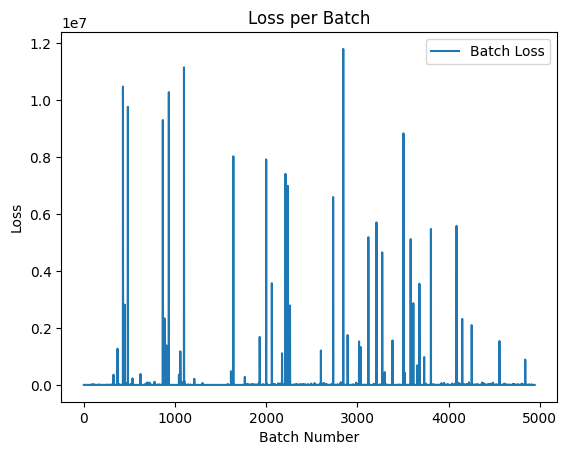

In [174]:
# One example training epopppch 
print("Training one epoch...")
losses = train_one_epoch(model, train_loader, criterion, optimizer)

# Plot the loss curve
plt.plot(losses, label="Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.legend()
plt.show()

In [119]:
# Calculates the model's total percentage error on a given dataset 
def evaluate_percent(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    total_percentage_error = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for artist, title, numerics, price in dataloader:
            # Calculate the model's prediction on the given artist, title and numerics
            outputs = model(artist, title, numerics)
            
            # Calculate absolute percentage error
            abs_percentage_error = torch.abs((outputs - price) / price) * 100
            
            # Accumulate the sum of percentage errors
            total_percentage_error += abs_percentage_error.sum().item()
            
            # Count the number of samples
            num_samples += price.size(0)
    
    # Calculate the mean percentage error
    print(num_samples)
    mean_percentage_error = total_percentage_error / num_samples
    return mean_percentage_error

In [123]:
print(f"Error of the model without training on the training set: {evaluate_percent(model, train_loader, criterion)}%")
print(f"Error of the model without training on the validation set: {evaluate_percent(model, val_loader, criterion)}%")

Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
316406
Error of the model without training on the training set: inf%
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
8326
Error of the model without training on the validation set: 756.8640615778017%


In [140]:
# Calculate the average loss of the model 
def evaluate_loss(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():
        for artist, title, numerics, price in dataloader:
            # Forward pass
            outputs = model(artist, title, numerics)
            loss = criterion(outputs, price)
            
            # Accumulate the loss
            running_loss += loss.item()
    
    return running_loss / len(dataloader)

In [141]:
print(f'Mean Squared Error of the untrained model on Validation Set: {evaluate_loss(model, val_loader, criterion)}')

Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Mean Squared Error of the untrained model on Validation Set: 1807.3191605196655


In [122]:
##### Training Loop 
num_epochs = 10
loss_plot = []  # keep a vector to plot the loss as we go 
average = []

for epoch in range(num_epochs):
    batch_losses = train_one_epoch(model, train_loader, criterion, optimizer)
    loss_plot.extend(batch_losses)  # Store losses for each batch
    
    # Print average loss for the epoch
    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    average.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_epoch_loss}")

# Plot the loss curve
plt.plot(loss_plot, label="Batch Loss")
plt.plot(average, label="Average Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.legend()
plt.show()

Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Epoch 1/10, Avg Train Loss: 670.8775326947901
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Epoch 2/10, Avg Train Loss: 663.7167872367457
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Epoch 3/10, Avg Train Loss: 645.8089267084417
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Epoch 4/10, Avg Train Loss: 675.7781636513118
Median Price: $2830.89
Mean Price: $31777.83
Normalized 

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/pytorch/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/pytorch/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aoden/PycharmProjects/PyTorch Art Project/scratch.py", line 69, in <module>
    dataset = ArtDataset()
              ^^^^^^^^^^^^
  File "/Users/aoden/PycharmProjects/PyTorch Art Project/scratch.py", line 36, in __init__
    self.title = text_to_tensor(title_col, vocab_title, max_len)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aoden/PycharmProjects/PyTorch Art Project/model.py", line 92, in text_to_tensor
    tokenized_text = tokenize(text)
                     ^^^^^^^^^^^^^^
  File "/Users/aod

KeyboardInterrupt: 

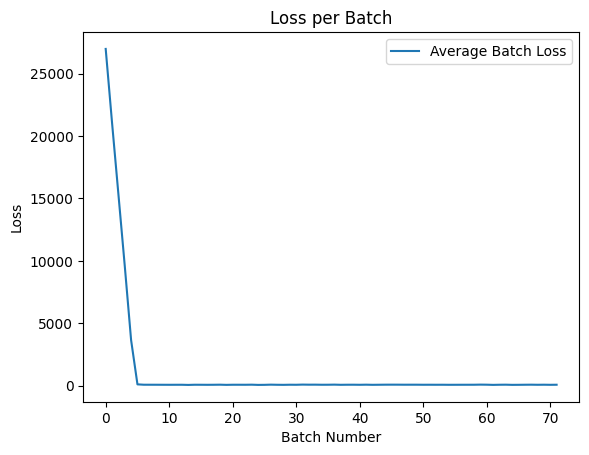

In [90]:
plt.plot(average, label="Average Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.legend()
plt.show()

In [176]:
def prediction_to_real_price(price_tensor): 
    return (price_tensor * dataset.price_std) + dataset.price_median

# Sample the Training Set 
index = 0
for index in range(64): 
    artist_test, title_test, numerics_test, price_test = dataset.__getitem__(index)
    artist_str, title_str = dataset.__getstring__(index)
    #print(artist_test.view(1, -1).shape)
    #print(f"Artist: {artist_str}")
    #print(f"Title: {title_str}")
    #print(f"Real Price: ${prediction_to_real_price(price_test).item():.2f}")
    prediction = model(artist_test.view(1, -1), title_test.view(1, -1), numerics_test.view(1, -1))
    #print(f"Model Prediction: ${prediction_to_real_price(prediction).item():.2f}")
    with torch.no_grad(): 
        print(criterion(price_test, prediction).item())

60.52694320678711
53.69417190551758
57.96465301513672
55.68706512451172
59.10344696044922
56.82585906982422
58.68259048461914
53.84270477294922
52.8400764465332
60.10608673095703
54.83296585083008
60.10608673095703
61.950439453125
52.8400764465332
54.54827117919922
56.25646209716797
61.52957534790039
63.65863037109375
56.25646209716797
52.98861312866211
79.31706237792969
59.10344696044922
56.25646209716797
54.69680404663086
58.24935531616211
60.8116455078125
77.89356994628906
55.40236282348633
53.69417190551758
57.67995834350586
59.10344696044922
72.19959259033203
69.35260772705078
54.26356887817383
56.25646209716797
79.31706237792969
55.11766815185547
54.412109375
56.82585906982422
134.83334350585938
60.52694320678711
55.11766815185547
60.10608673095703
77.89356994628906
60.52694320678711
60.8116455078125
53.40947341918945
56.25646209716797
54.26356887817383
53.2733154296875
54.26356887817383
54.54827117919922
61.52957534790039
67.92910766601562
59.38814926147461
56.25646209716797
56.

In [181]:

print(f"Artist: {artist_str}")
print(f"Title: {title_str}")
print(f"Real Price: ${prediction_to_real_price(price_test).item():.2f}")
prediction = model(artist_test.view(1, -1), title_test.view(1, -1), numerics_test.view(1, -1))
print(f"Model Prediction: ${prediction_to_real_price(prediction).item():.2f}")

Artist: Clarence Lawson Wood
Title: A Portrait of a Spaniel called 'Peter'
Real Price: $127.01
Model Prediction: $-3100.24


In [180]:
with torch.no_grad(): 
    print(criterion(price_test, prediction))

tensor(54.4121)


In [179]:
print("Real Price Normalized: ", price_test)
prediction = model(artist_test.view(1, -1), title_test.view(1, -1), numerics_test.view(1, -1))
print("Model Prediction Normalized: ", prediction)

Real Price Normalized:  tensor([-0.0096])
Model Prediction Normalized:  tensor([[-0.0210]], grad_fn=<AddmmBackward0>)


In [182]:
# Print all weights and biases
for name, param in model.state_dict().items():
    print(f"{name}:\n{param}\n")

embedding_artist.weight:
tensor([[ 0.5790, -0.4885,  0.5028,  ...,  0.2704, -0.5964,  1.2841],
        [ 0.5434,  0.6994,  2.3200,  ..., -1.9654,  1.0502,  0.6747],
        [ 0.0859, -1.2170,  0.1348,  ..., -0.5003, -0.1863, -1.0120],
        ...,
        [ 1.7231, -0.6692, -1.3873,  ..., -0.5411,  1.5035,  0.9612],
        [ 1.5455,  0.9112,  0.8516,  ...,  0.4223, -0.6804,  1.5940],
        [ 0.0170,  0.2978, -0.6556,  ..., -0.0844, -0.3973, -0.8191]])

embedding_title.weight:
tensor([[-0.2644, -0.7519, -0.8351, -0.4711, -0.8172],
        [-0.1354, -1.5789,  0.9315,  0.9238,  0.1252],
        [-1.2062, -0.0730, -1.0433,  0.4100,  1.4051],
        ...,
        [ 1.4080, -0.9338, -0.4730, -0.2465, -0.0579],
        [ 0.4932,  1.0302, -1.2647, -1.2963,  1.1343],
        [-0.3305,  0.2982, -0.1790,  0.1594, -0.3899]])

fc1.weight:
tensor([[-1.1459e-01,  1.3771e-02,  9.6295e-02,  6.7377e-02,  4.7498e-03,
          2.2408e-01, -1.0851e-01, -2.5300e-02,  1.8911e-01,  9.1038e-02,
          2